# Analysis of the chains

here I am mainly concerned with plotting H0 distributions.

### matplotlib settings and test run (suppressed)

In [1]:
from getdist import MCSamples, plots
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import glob
import os

#plt.style.use("ggplot")        # if you want a more distinct style
plt.style.use("seaborn-v0_8-muted")
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
# Load the damn data
data = np.loadtxt("/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/2025-12-19_1000000__1.txt")

# Get param names  
with open("/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/2025-12-19_1000000_.paramnames") as f:
    paramnames = [line.split()[0] for line in f]

# Skip first 2 columns, take only parameter columns
params = data[:, 2:2+len(paramnames)]

# Replace underscores in labels to avoid LaTeX parsing
clean_labels = [name.replace('_', ' ') for name in paramnames]

# Create samples with clean labels
samples = MCSamples(samples=params, names=paramnames, labels=clean_labels)

# Force no LaTeX
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples], filled=True)

#plt.show()

Removed no burn in


### Functions: load chains and plot H0 posteriors

Found 4 chain files
Loaded 2025-12-19_1000000__2.txt: 1890 samples
Loaded 2025-12-19_1000000__3.txt: 1955 samples
Loaded 2025-12-19_1000000__1.txt: 1835 samples
Loaded 2025-12-19_1000000__4.txt: 1865 samples


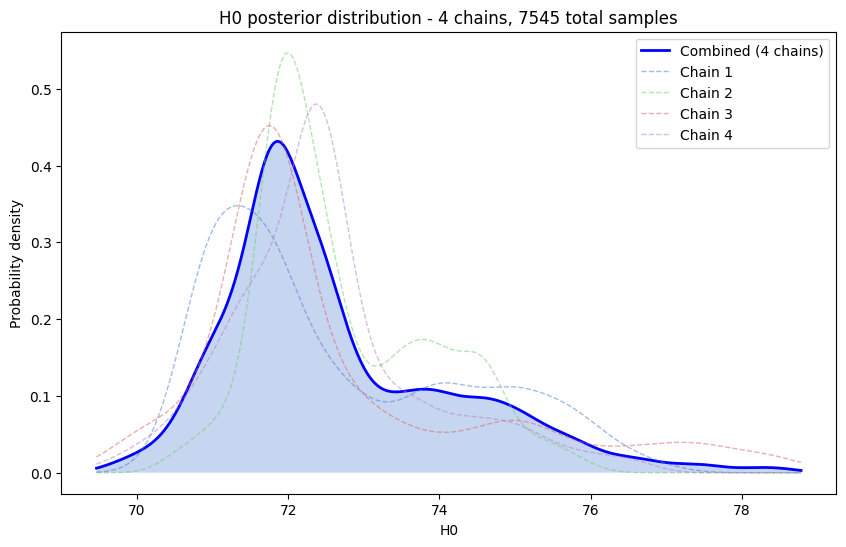

Combined H0: 72.63 ± 1.55
Total samples: 7545
Number of chains: 4


In [2]:

def load_chains(chain_pattern):
    """Load multiple chains, filtering out malformed/empty ones"""
    all_h0 = []
    
    # Find all matching chain files
    chain_files = glob.glob(chain_pattern)
    print(f"Found {len(chain_files)} chain files")
    
    for chain_file in chain_files:
        try:
            data = np.loadtxt(chain_file)
            
            # Skip if file is empty or too short
            if len(data) < 100:  # Minimum 100 samples
                print(f"Skipping {os.path.basename(chain_file)}: too short ({len(data)} samples)")
                continue
                
            # Get H0 values (3rd column, index 2)
            h0_values = data[:, 2]
            
            # Skip if H0 values are nonsense (outside reasonable range)
            if np.any(h0_values < 50) or np.any(h0_values > 100):
                print(f"Skipping {os.path.basename(chain_file)}: H0 values out of reasonable range")
                continue
                
            all_h0.append(h0_values)
            print(f"Loaded {os.path.basename(chain_file)}: {len(h0_values)} samples")
            
        except Exception as e:
            print(f"Failed to load {os.path.basename(chain_file)}: {e}")
            continue
    
    return all_h0

# Load all valid chains
chain_pattern = "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/2025-12-19_1000000__*.txt"
all_h0_chains = load_chains(chain_pattern)

if not all_h0_chains:
    print("No valid chains found!")
else:
    # Combine all chains
    combined_h0 = np.concatenate(all_h0_chains)
    
    # Create KDE for smooth distribution
    kde = stats.gaussian_kde(combined_h0)
    x_vals = np.linspace(combined_h0.min(), combined_h0.max(), 1000)
    y_vals = kde(x_vals)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, 'b-', linewidth=2, label=f'Combined ({len(all_h0_chains)} chains)')
    plt.fill_between(x_vals, y_vals, alpha=0.3)
    
    # Also plot individual chains if you want to see them
    for i, h0_chain in enumerate(all_h0_chains):
        if len(h0_chain) > 100:  # Only plot if reasonably sized
            kde_individual = stats.gaussian_kde(h0_chain)
            y_individual = kde_individual(x_vals)
            plt.plot(x_vals, y_individual, '--', alpha=0.5, linewidth=1, label=f'Chain {i+1}')
    
    plt.xlabel('H0')
    plt.ylabel('Probability density')
    plt.title(f'H0 posterior distribution - {len(all_h0_chains)} chains, {len(combined_h0)} total samples')
    plt.legend()
    plt.show()
    
    # Calculate combined statistics
    mean = np.mean(combined_h0)
    std = np.std(combined_h0)
    print(f"Combined H0: {mean:.2f} ± {std:.2f}")
    print(f"Total samples: {len(combined_h0)}")
    print(f"Number of chains: {len(all_h0_chains)}")

In [3]:
from pathlib import Path

def load_chains_from_folder(folder_path):
    """Load all valid chains from a folder"""
    all_h0 = []
    

    # patterns_priority = [
    #     "*2000000__*.txt",
    #     "*1010000__*.txt",
    # ]

    # # collect higher-priority files
    # chain_files = []
    # for pattern in patterns_priority:
    #     chain_files.extend(glob.glob(str(folder_path / pattern)))

    # # fallback if none found
    # if not chain_files:
    chain_files = glob.glob(str(folder_path / "*__*.txt"))
    for chain_file in chain_files:
        try:
            data = np.loadtxt(chain_file)
            
            # Skip if file is empty or too short
            if len(data) < 100:
                continue
                
            # Get H0 values (3rd column, index 2)
            h0_values = data[:, 2]
            
            # Skip if H0 values are nonsense
            if np.any(h0_values < 50) or np.any(h0_values > 100):
                continue
                
            all_h0.append(h0_values)
            
        except Exception as e:
            continue
    
    if all_h0:
        return np.concatenate(all_h0)
    else:
        return None

def plot_axion_group(chain_names, group_name, base_path):
    """Plot H0 distributions for a group of chains"""
    plt.figure(figsize=(12, 8))
    
    # Colors for different lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(chain_names)))
    
    for i, chain_folder in enumerate(chain_names):
        folder_path = base_path / chain_folder
        print(f"Processing {chain_folder}...")
        
        if not folder_path.exists():
            print(f"  Folder does not exist: {folder_path}")
            continue
            
        h0_data = load_chains_from_folder(folder_path)
        
        if h0_data is not None and len(h0_data) > 0:
            # Create KDE
            kde = stats.gaussian_kde(h0_data)
            x_vals = np.linspace(60, 80, 1000)
            y_vals = kde(x_vals)
            
            # Clean up the label
            label = chain_folder.replace(f'{group_name}_', '').replace('planck_TTTEEElensing_', '')
            
            plt.plot(x_vals, y_vals, color=colors[i], linewidth=2, label=label)
            
            # Calculate statistics
            mean = np.mean(h0_data)
            std = np.std(h0_data)
            print(f"  {label}: H0 = {mean:.2f} ± {std:.2f} (n={len(h0_data)})")
    
    plt.xlim(65,75)
    plt.xlabel('H0', fontsize=14)
    plt.ylabel('Probability density', fontsize=14)
    plt.title(f'H0 posterior distributions - {group_name}', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Base path
base = Path("/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp")

# Define your groups
names_1_ax = [
    "1_ax_planck_TTTEEElensing2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21",
]

names_1_boss_vs_desi = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_boss2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_boss2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21",
] 

names_4_ax = [
    "4_ax_planck_TTTEEElensing_pantheon_plus2025-11-12",
    "4_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-12",
]

names_9_ax = [
    "planck_TTTEEElensing_mAxi_shooting2025-11-14",
    "9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19",
]

names_9_boss_vs_desi = [
    "9_axions/planck_TTTEEElensing_pantheon_plus_boss_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_boss_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19",
]
# Plot each group
#plot_axion_group(names_1_ax, "1 Axion", base)
#plot_axion_group(names_4_ax, "4 Axions", base)
#plot_axion_group(names_9_ax, "9 Axions", base)
#plot_axion_group(names_0_ax, "0 Axions (Baseline)", base)

## Here we compare 1 vs 9 axions for each given dataset. 
for the H0 posterior

Processing 1_ax_planck_TTTEEElensing2025-11-21...
  1_ax_planck_TTTEEElensing2025-11-21: H0 = 67.83 ± 1.10 (n=84865)
Processing planck_TTTEEElensing_mAxi_shooting2025-11-14...
  mAxi_shooting2025-11-14: H0 = 74.24 ± 1.90 (n=83795)


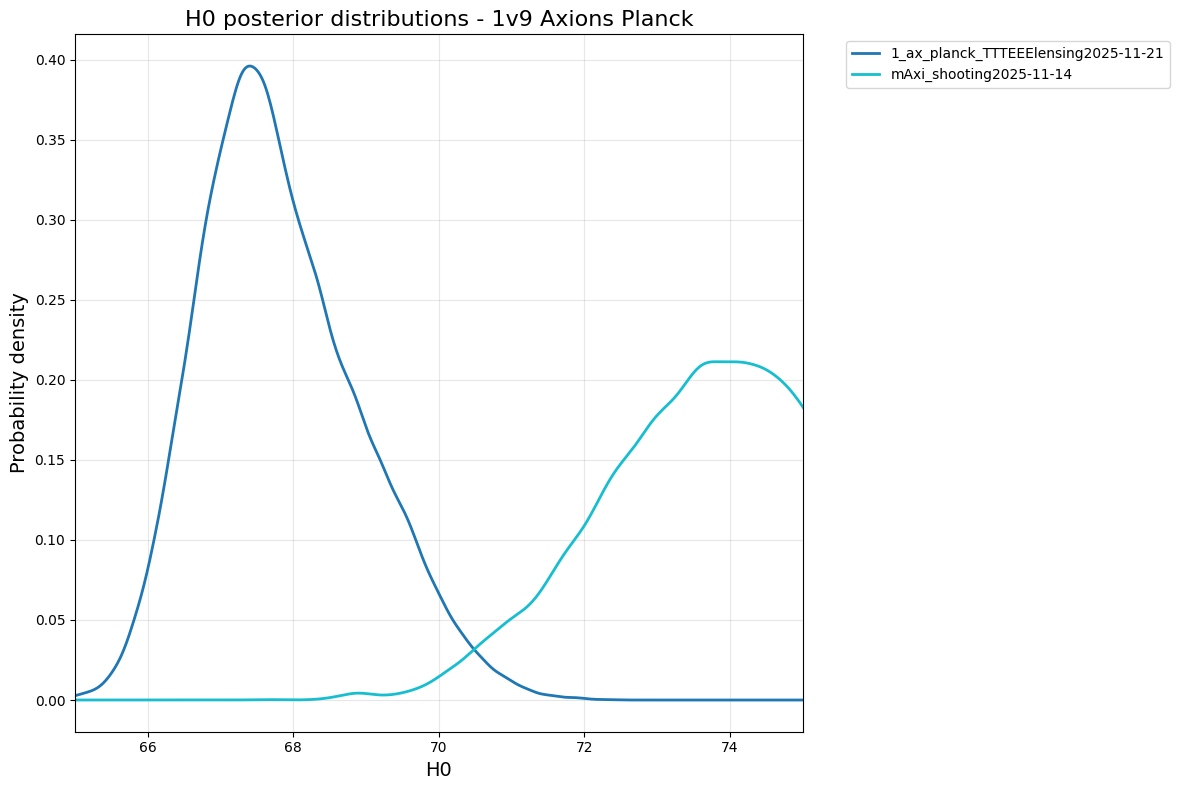

Processing 1_ax_planck_TTTEEElensing_pantheon_plus2025-11-21...
  1_ax_pantheon_plus2025-11-21: H0 = 67.76 ± 0.95 (n=47680)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19...
  9_axions/pantheon_plus_2025-12-19: H0 = 72.63 ± 1.55 (n=7545)


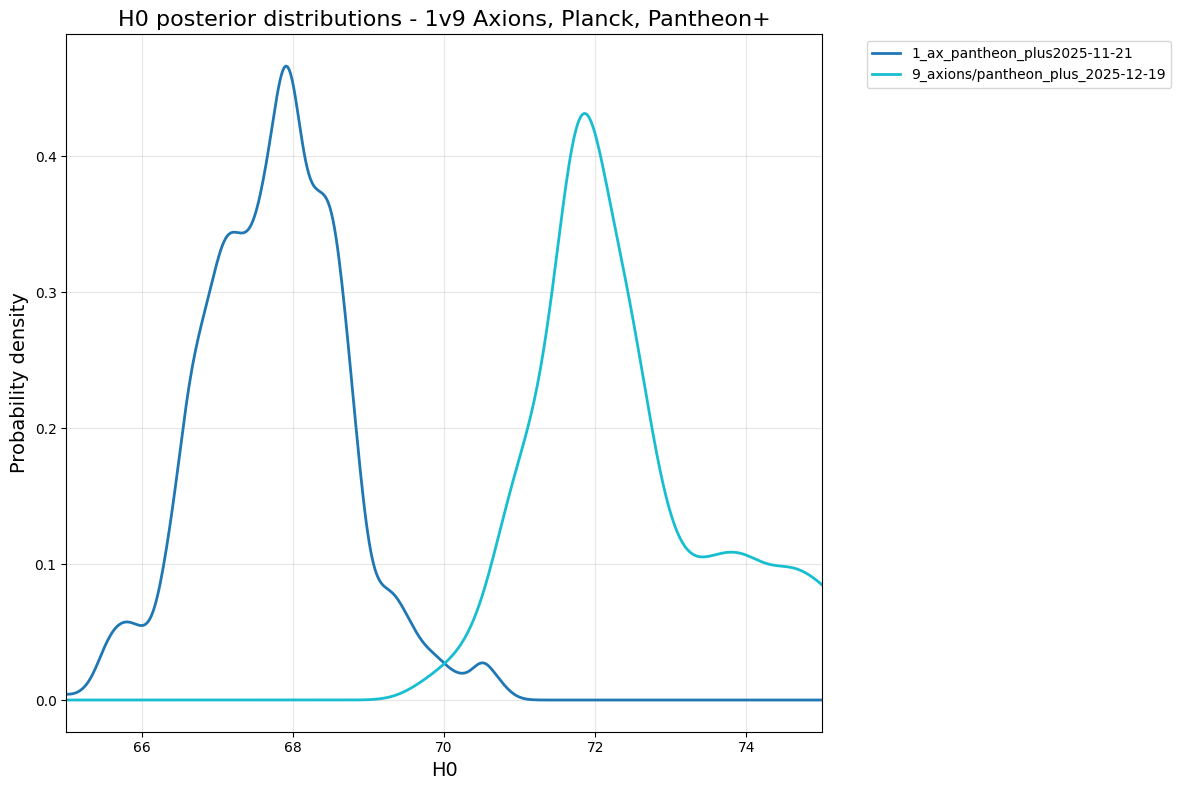

Processing 1_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-21...
  1_ax_pantheon_plus_sh0es2025-11-21: H0 = 70.99 ± 1.14 (n=36730)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19...
  9_axions/pantheon_plus_sh0es_2025-12-19: H0 = 73.11 ± 0.91 (n=10210)


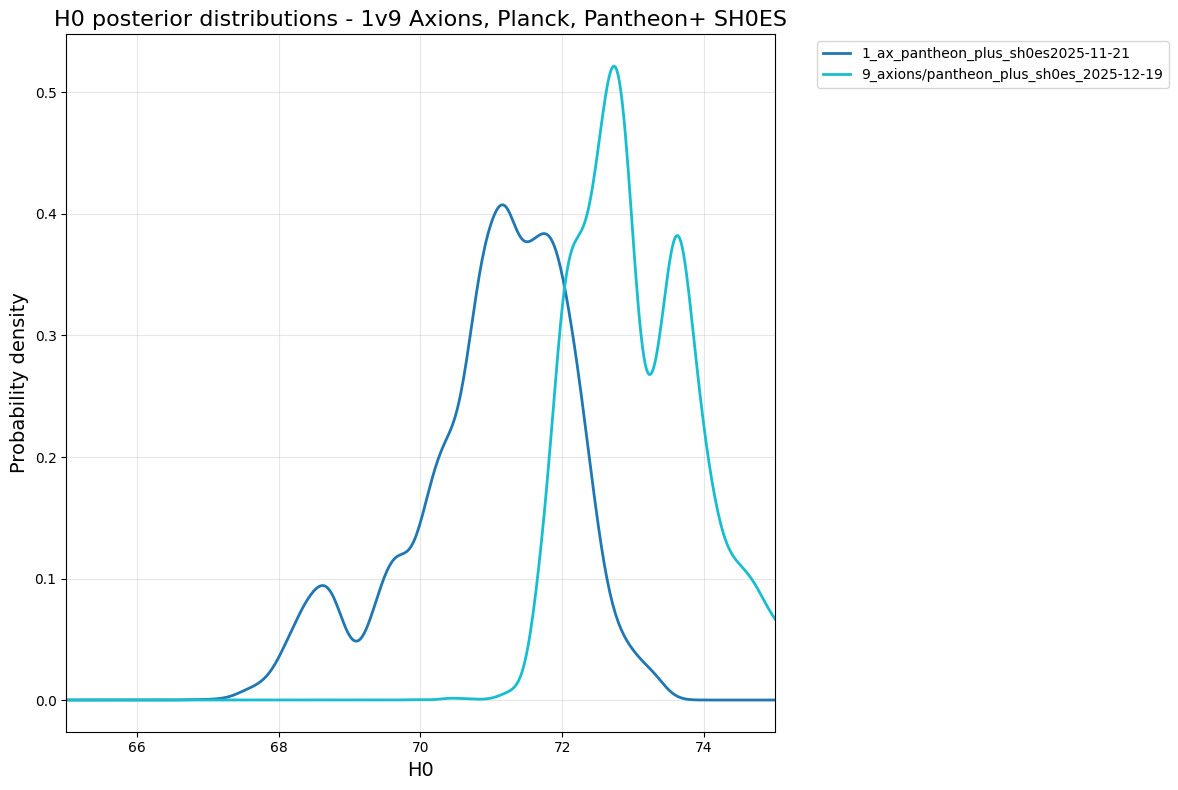

Processing 1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21...
  1_ax_pantheon_plus_desi2025-11-21: H0 = 69.12 ± 0.79 (n=50065)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19...
  9_axions/pantheon_plus_desi_2025-12-19: H0 = 72.16 ± 0.73 (n=4595)


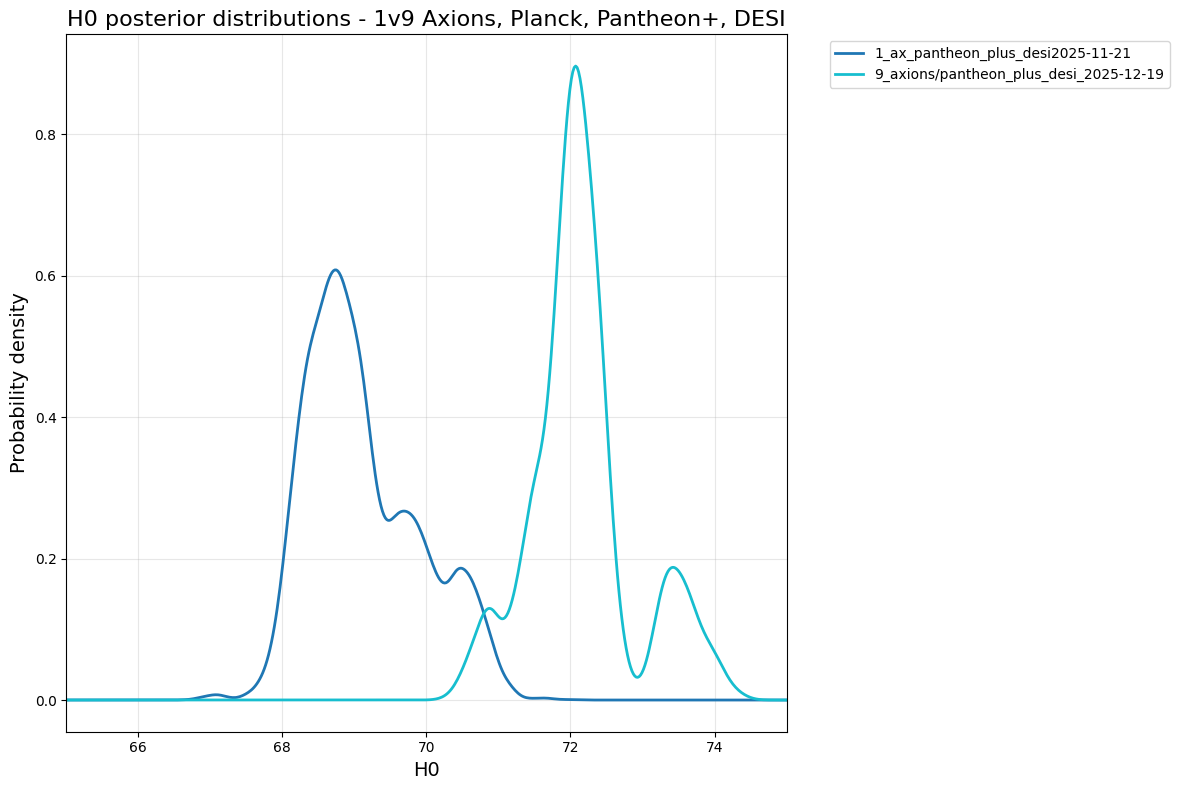

Processing 1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21...
  1_ax_pantheon_plus_sh0es_desi2025-11-21: H0 = 71.29 ± 1.12 (n=39665)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19...
  9_axions/pantheon_plus_sh0es_desi_2025-12-19: H0 = 72.89 ± 0.73 (n=4585)


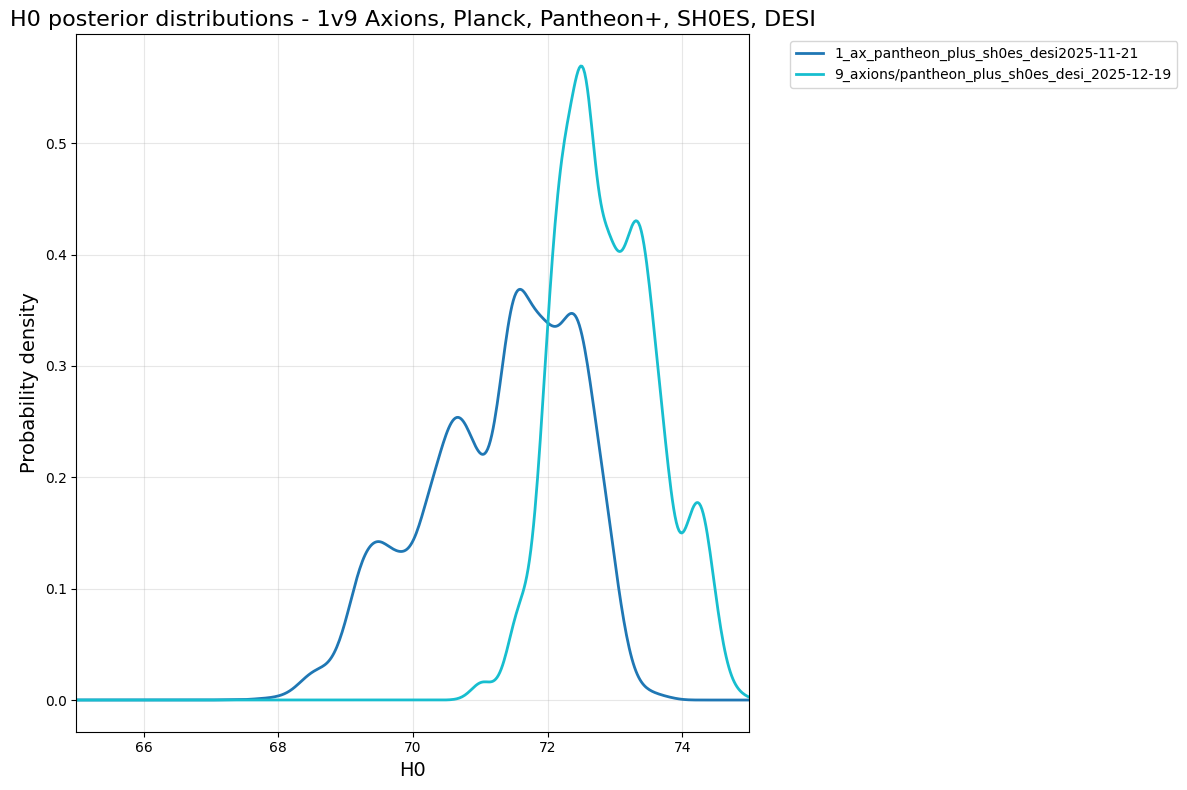

In [4]:

# Define your groups
planck_1_vs_9 = [
    "1_ax_planck_TTTEEElensing2025-11-21",
    "planck_TTTEEElensing_mAxi_shooting2025-11-14",
    ]

pantheon_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19",
    ]

pantheon_sh0es_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19",
    ]
pantheon_desi_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19",
    ]
pantheon_sh0es_desi_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19",
    ]
# Plot each group
plot_axion_group(planck_1_vs_9, "1v9 Axions Planck", base)
plot_axion_group(pantheon_1_vs_9, "1v9 Axions, Planck, Pantheon+", base)
plot_axion_group(pantheon_sh0es_1_vs_9, "1v9 Axions, Planck, Pantheon+ SH0ES", base)
plot_axion_group(pantheon_desi_1_vs_9, "1v9 Axions, Planck, Pantheon+, DESI", base)
plot_axion_group(pantheon_sh0es_desi_1_vs_9, "1v9 Axions, Planck, Pantheon+, SH0ES, DESI", base)
#plot_axion_group(names_0_ax, "0 Axions (Baseline)", base)

Processing 4_ax_planck_TTTEEElensing_pantheon_plus2025-11-12...
  4_ax_pantheon_plus2025-11-12: H0 = 68.27 ± 0.86 (n=66355)
Processing 4_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-12...
  4_ax_pantheon_plus_sh0es2025-11-12: H0 = 70.88 ± 1.56 (n=74970)


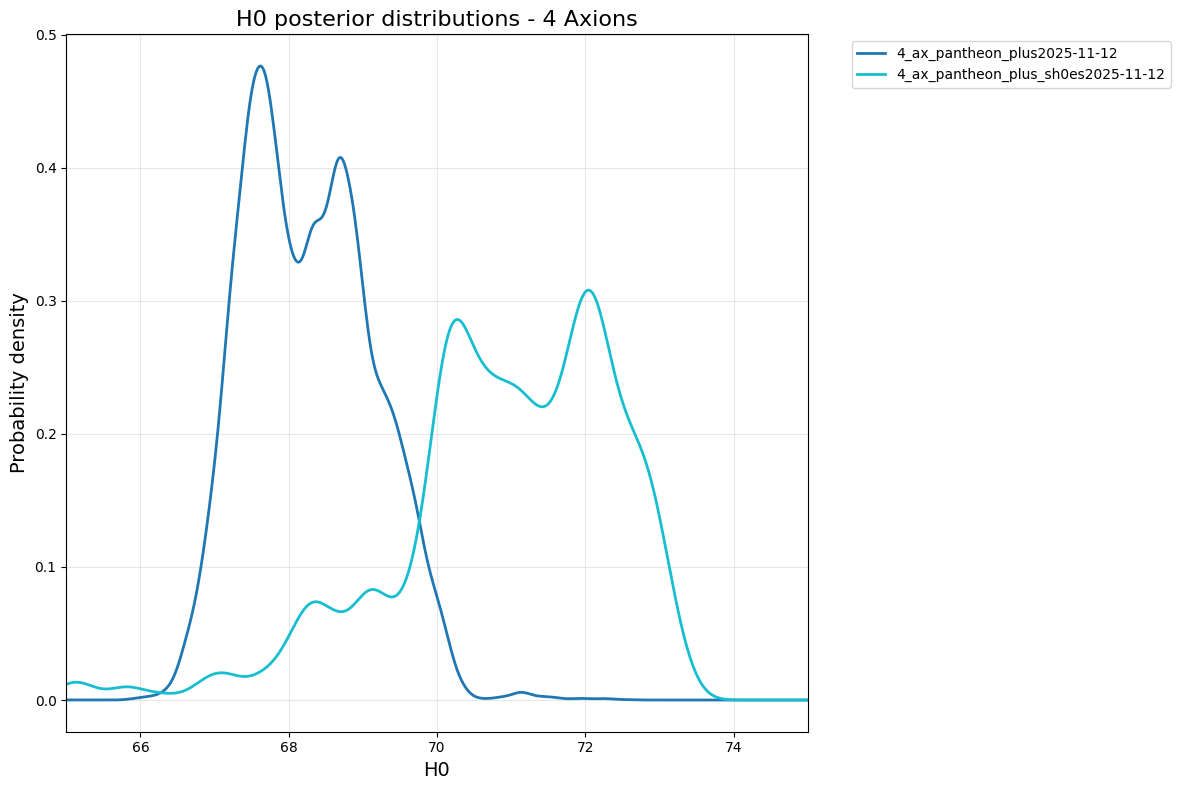

In [5]:

plot_axion_group(names_4_ax, "4 Axions", base)

## Here we compare 1 vs 9 axions for each given dataset. 
for the H0 posterior

In [6]:
def load_samples(chain_glob, param_indices):
    chain_files = glob.glob(chain_glob)

    all_weights = []
    all_samples_selected = []

    for chain_file in chain_files:
        try:
            data = np.loadtxt(chain_file)
            if len(data) < 100:
                continue

            weights = data[:, 0]
            selected_cols = np.column_stack(
                [data[:, idx+2] for idx in param_indices.values()]
            )

            all_weights.append(weights)
            all_samples_selected.append(selected_cols)

        except:
            continue

    weights = np.concatenate(all_weights)
    samples = np.concatenate(all_samples_selected)

    return MCSamples(
        samples=samples,
        weights=weights,
        names=list(param_indices.keys()),
        labels=[latex_labels[name] for name in param_indices.keys()],
        ignore_rows=0.2 #20 percent burnin?
    )


def load_single_samples(chain_glob, param_indices):
    chain_files = glob.glob(chain_glob)

    all_chains_samples = []

    for chain_file in chain_files:
        try:
            data = np.loadtxt(chain_file)
            if len(data) < 100:
                continue

            weights = data[:, 0]
            selected_cols = np.column_stack(
                [data[:, idx+2] for idx in param_indices.values()]
            )

            mc_sample = MCSamples(
                samples=selected_cols,
                weights=weights,
                names=list(param_indices.keys()),
                labels=[latex_labels[name] for name in param_indices.keys()],
                ignore_rows=0.2 #20 percent burnin?
            )
            all_chains_samples.append(mc_sample)
        except:
             continue

    return all_chains_samples




latex_labels = {
    'H0': r'H_0',
    'omega_b': r'10^{-2}\,\omega_b',
    'omega_cdm': r'\omega_{\rm cdm}',
    'ln10^{10}A_s': r'\ln(10^{10} A_s)',
    'n_s': r'n_s',
    'tau_reio': r'\tau_{\rm reio}',

    'fraction_maxion_ac__1': r'f^{(1)}_{\rm ax}',
    'fraction_maxion_ac__2': r'f^{(2)}_{\rm ax}',
    'fraction_maxion_ac__3': r'f^{(3)}_{\rm ax}',
    'fraction_maxion_ac__4': r'f^{(4)}_{\rm ax}',
    'fraction_maxion_ac__5': r'f^{(5)}_{\rm ax}',
    'fraction_maxion_ac__6': r'f^{(6)}_{\rm ax}',
    'fraction_maxion_ac__7': r'f^{(7)}_{\rm ax}',
    'fraction_maxion_ac__8': r'f^{(8)}_{\rm ax}',
    'fraction_maxion_ac__9': r'f^{(9)}_{\rm ax}',

    'A_planck': r'A_{\rm Planck}',
    'M': r'M',
    'z_reio': r'z_{\rm reio}',

    'Omega_Lambda': r'\Omega_\Lambda',
    'Omega_m': r'\Omega_m',

    'YHe': r'Y_{\rm He}',
    '100theta_s': r'100\,\theta_s',

    'A_s': r'A_s',
    'sigma8': r'\sigma_8',

    'rs_d': r'r_s^{\rm drag}',
    'a_eq': r'a_{\rm eq}',
    'k_eq': r'k_{\rm eq}',

    'rd_star': r'r_d^\star',
    'rs_star': r'r_s^\star',
    'da_star': r'D_A^\star',
    'z_star': r'z^\star',

    'rs_rec': r'r_s^{\rm rec}',
    'da_rec': r'D_A^{\rm rec}',
    'z_rec': r'z_{\rm rec}',

    'age': r't_0',
    'theta_star_100': r'100\,\theta_\star',
}

latex_labels_1 = {
    'H0':r'H_0',
    'omega_b': r'10^{-2}\omega{}_{b }',
    'omega_cdm': r'\omega{}_{cdm }',
    'ln10^{10}A_s': r'ln10^{10}A_{s }',
    'n_s': r'n_{s}',
    'tau_reio': r'\tau{}_{reio }',
    'fraction_maxion_ac__1': r'fraction_{maxion ac  1 }',
    'log10_maxion_ac__1': r'log10_{maxion ac  1 }',
    'A_planck': r'A_{planck }',
    'M': r'M',
}

# 9 Axions Pantheon+ vs Panthoen+ SH0ES vs Pantheon+ SH0ES DESI

Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in


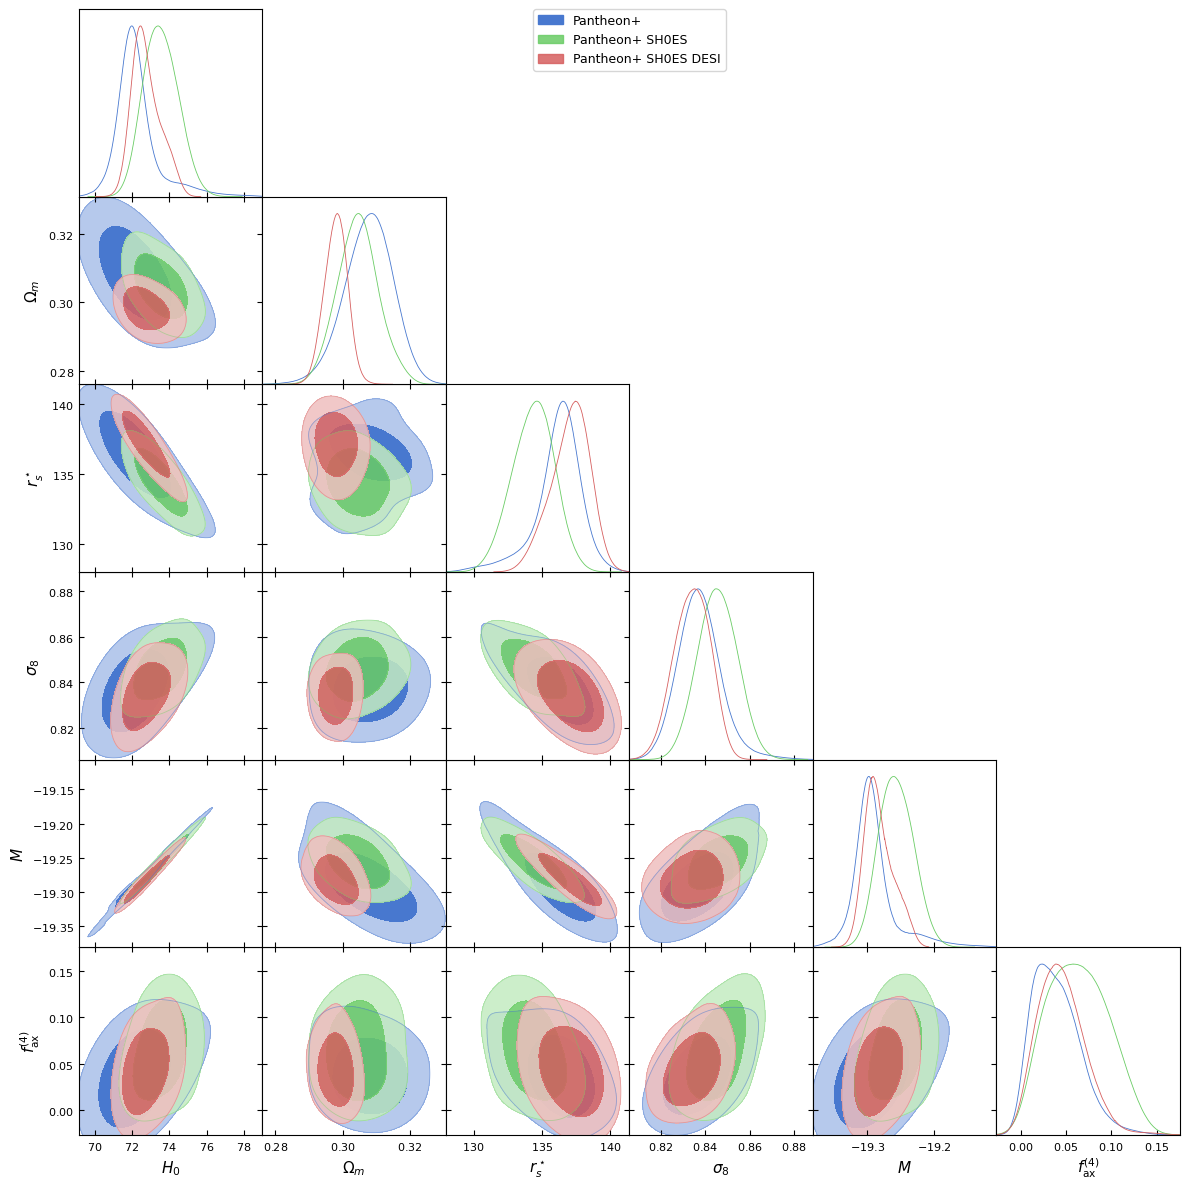

In [7]:
param_names = ['H0','Omega_m','rs_star','sigma8','M','fraction_maxion_ac__4']
param_indices = {name: i for i, name in enumerate(latex_labels) if name in param_names}

samp_1 = load_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/*__*.txt",
    param_indices
)

samp_2 = load_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-23/*__*.txt",
    param_indices
)

samp_3 = load_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19/*__*.txt",
    param_indices
)

g = plots.get_subplot_plotter()

g.triangle_plot(
    [samp_1, samp_2, samp_3],
    params=param_names,
    filled=True,
    legend_labels=[
        "Pantheon+",
        "Pantheon+ SH0ES",
        "Pantheon+ SH0ES DESI"
    ],
    contour_colors=[colors[0],colors[1],colors[2]]
)


g.settings.lab_fontsize = 14       # axis labels
g.settings.axes_fontsize = 12      # tick labels
g.settings.legend_fontsize = 12    # legend
g.settings.legend_loc = (1.05, 1)  # move legend outside
g.settings.alpha_filled_add = 0.7   # filled contours transparency
g.settings.linewidth = 2


plt.show()


# Analysis of the chains

here I am mainly concerned with plotting H0 distributions.

# triangle MCMC

# Test pantheon + sh0es vs normal pantheon+ sh0es

Removed 0.2 as burn in
Removed 0.2 as burn in


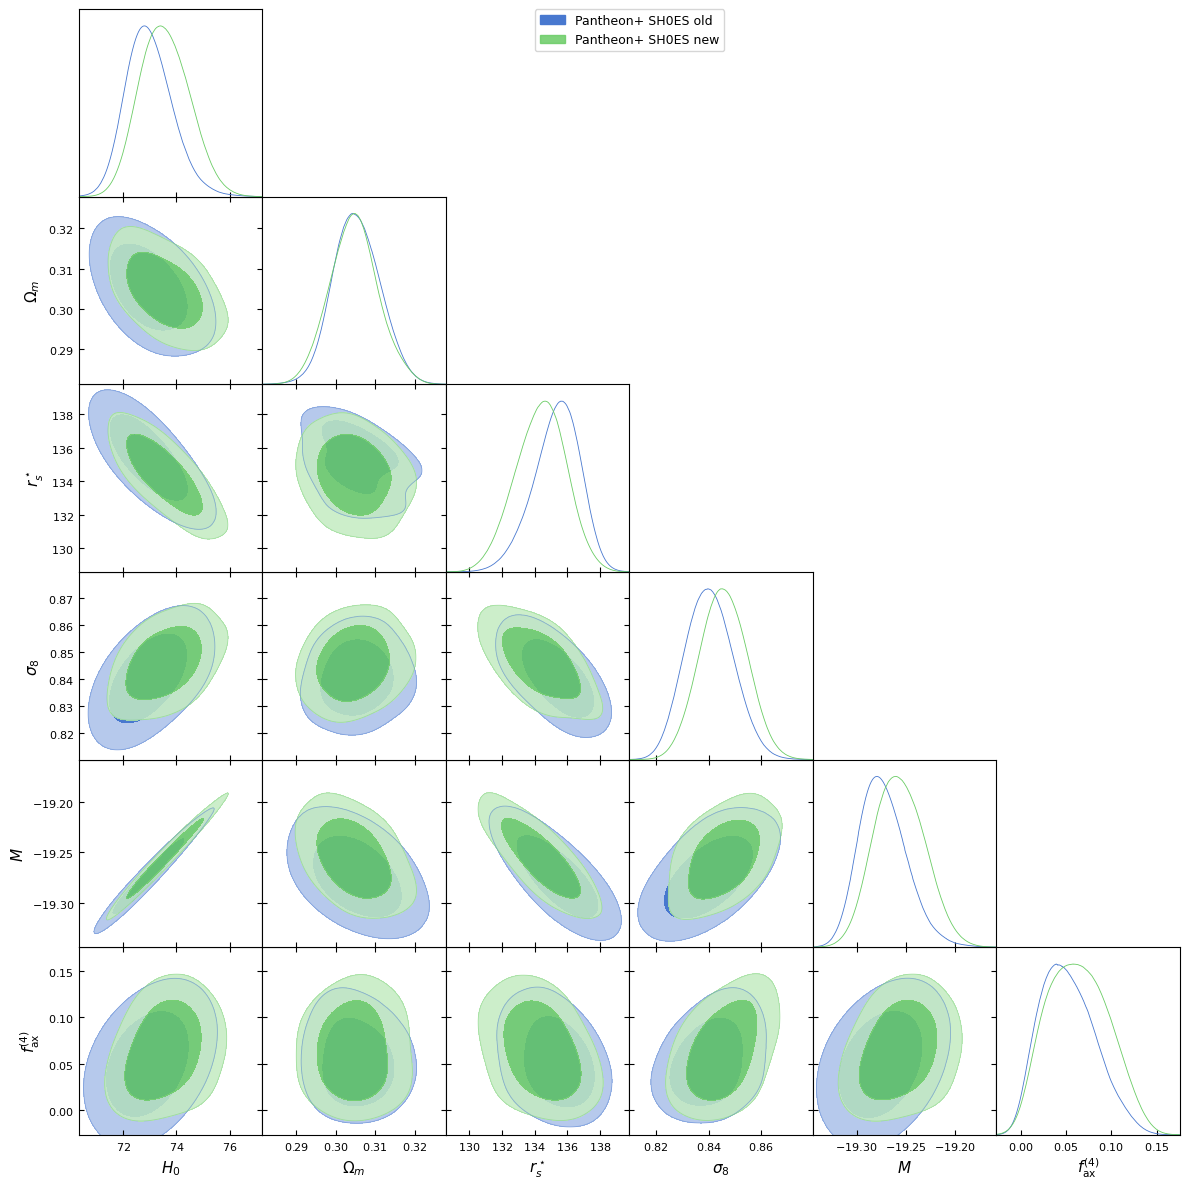

In [8]:
param_names = ['H0','Omega_m','rs_star','sigma8','M','fraction_maxion_ac__4']
param_indices = {name: i for i, name in enumerate(latex_labels) if name in param_names}

samp_1 = load_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19/*__*.txt",
    param_indices
)

samp_2 = load_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-23/*__*.txt",
    param_indices
)
g = plots.get_subplot_plotter()

g.triangle_plot(
    [samp_1, samp_2],
    params=param_names,
    filled=True,
    legend_labels=[
        "Pantheon+ SH0ES old",
        "Pantheon+ SH0ES new"
    ],
    contour_colors=[colors[0],colors[1]]
)


g.settings.lab_fontsize = 14       # axis labels
g.settings.axes_fontsize = 12      # tick labels
g.settings.legend_fontsize = 12    # legend
g.settings.legend_loc = (1.05, 1)  # move legend outside
g.settings.alpha_filled_add = 0.7   # filled contours transparency
g.settings.linewidth = 2

plt.show()


Removed 0.2 as burn in
Removed 0.2 as burn in


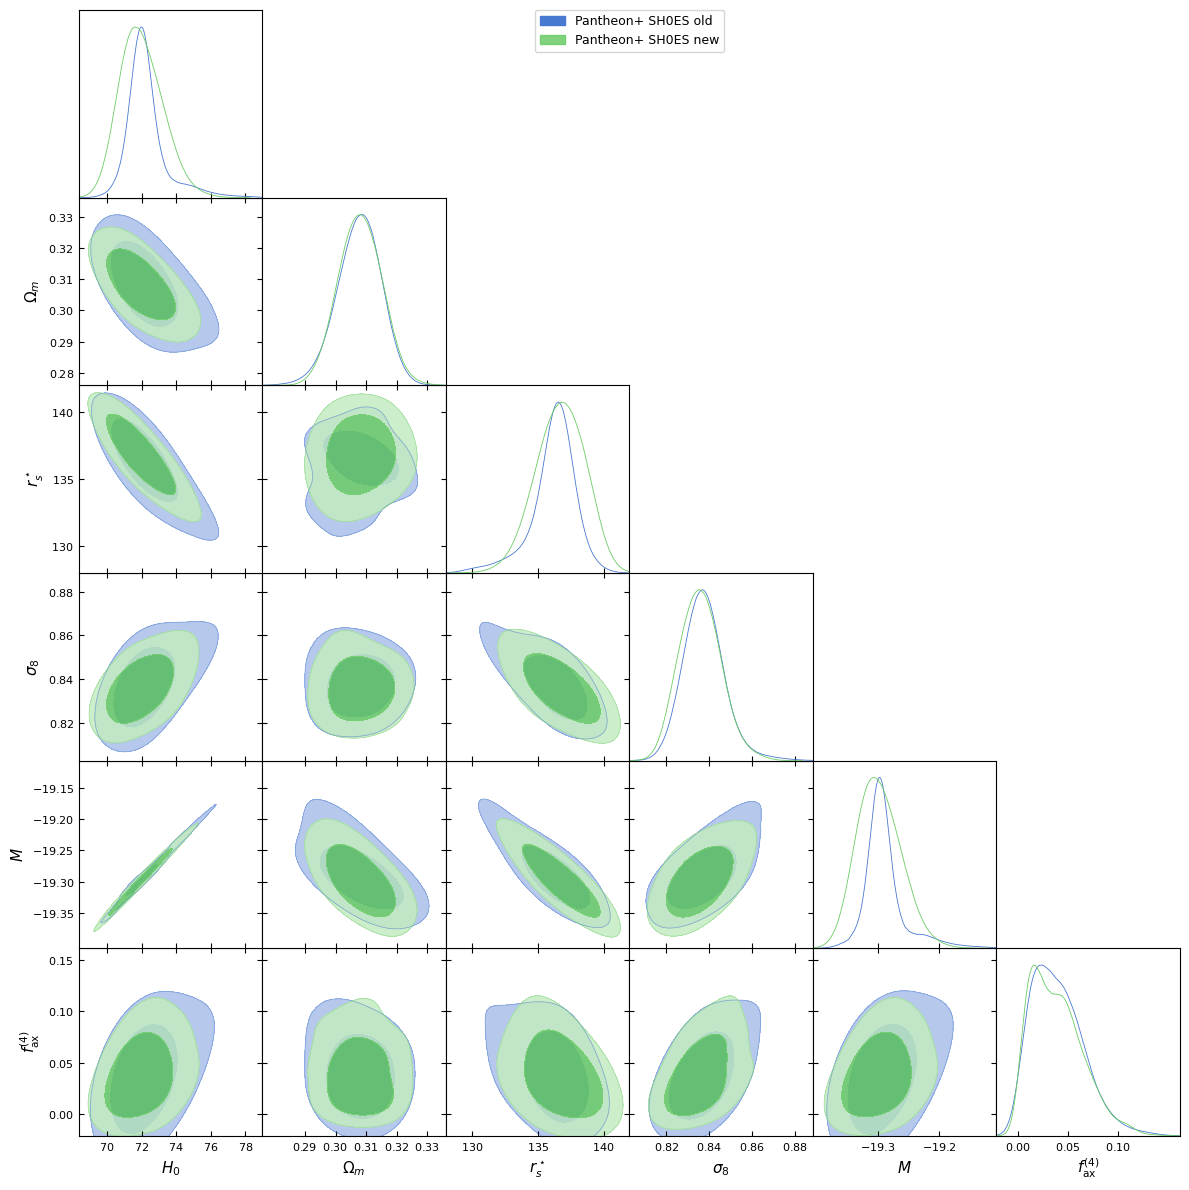

In [9]:
param_names = ['H0','Omega_m','rs_star','sigma8','M','fraction_maxion_ac__4']
param_indices = {name: i for i, name in enumerate(latex_labels) if name in param_names}

samp_1 = load_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/*__*.txt",
    param_indices
)

samp_2 = load_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_2025-12-24/*__*.txt",
    param_indices
)
g = plots.get_subplot_plotter()

g.triangle_plot(
    [samp_1, samp_2],
    params=param_names,
    filled=True,
    legend_labels=[
        "Pantheon+ SH0ES old",
        "Pantheon+ SH0ES new"
    ],
    contour_colors=[colors[0],colors[1]]
)


g.settings.lab_fontsize = 14       # axis labels
g.settings.axes_fontsize = 12      # tick labels
g.settings.legend_fontsize = 12    # legend
g.settings.legend_loc = (1.05, 1)  # move legend outside
g.settings.alpha_filled_add = 0.7   # filled contours transparency
g.settings.linewidth = 2

plt.show()


In [10]:
def compute_gelman_rubin(samples_list):
    """Compute Gelman-Rubin R-1 for a list of MCSamples"""
    # Get parameter names from the MCSamples object
    param_names = samples_list[0].getParamNames().names
    results = {}
    
    for i, name in enumerate(param_names):
        # Get this parameter from all chains
        chain_data = [chain.samples[:, i] for chain in samples_list]
        
        # Within-chain variance
        W = np.mean([np.var(chain, ddof=1) for chain in chain_data])
        
        # Between-chain variance  
        chain_means = [np.mean(chain) for chain in chain_data]
        n_total = sum(len(c) for c in chain_data)
        B = np.var(chain_means, ddof=1) * n_total / len(chain_data)
        
        # R-1
        var_plus = (n_total - 1) / n_total * W + B / n_total
        results[name] = np.sqrt(var_plus / W)
    
    return results

In [11]:

samp_1_chains = load_single_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19/*__*.txt",
    param_indices
)

samp_2_chains = load_single_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-23/*__*.txt",
    param_indices
)

# Compute R-1
r1_1 = compute_gelman_rubin(samp_1_chains)
r1_2 = compute_gelman_rubin(samp_2_chains)

# Print results
print("Run 1 R-1:")
for param, value in r1_1.items():
    print(f"  {param}: {value:.4f} {'✓' if value < 1.1 else '✗'}")

print("\nRun 2 R-1:")  
for param, value in r1_2.items():
    print(f"  {param}: {value:.4f} {'✓' if value < 1.1 else '✗'}")

Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Run 1 R-1:
  H0	H_0: 1.0194 ✓
  fraction_maxion_ac__4	f^{(4)}_{\rm ax}: 1.0033 ✓
  M	M: 1.0194 ✓
  Omega_m	\Omega_m: 1.0037 ✓
  sigma8	\sigma_8: 1.0038 ✓
  rs_star	r_s^\star: 1.0102 ✓

Run 2 R-1:
  H0	H_0: 1.0096 ✓
  fraction_maxion_ac__4	f^{(4)}_{\rm ax}: 1.0009 ✓
  M	M: 1.0107 ✓
  Omega_m	\Omega_m: 1.0008 ✓
  sigma8	\sigma_8: 1.0039 ✓
  rs_star	r_s^\star: 1.0095 ✓


In [12]:

samp_1_chains = load_single_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/*__*.txt",
    param_indices
)

samp_2_chains = load_single_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/9_axions_test/planck_TTTEEElensing_pantheon_plus_2025-12-24/*__*.txt",
    param_indices
)

# Compute R-1
r1_1 = compute_gelman_rubin(samp_1_chains)
r1_2 = compute_gelman_rubin(samp_2_chains)

# Print results
print("Run 1 R-1:")
for param, value in r1_1.items():
    print(f"  {param}: {value:.4f} {'✓' if value < 1.1 else '✗'}")

print("\nRun 2 R-1:")  
for param, value in r1_2.items():
    print(f"  {param}: {value:.4f} {'✓' if value < 1.1 else '✗'}")

Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in


Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Run 1 R-1:
  H0	H_0: 1.0009 ✓
  fraction_maxion_ac__4	f^{(4)}_{\rm ax}: 1.0083 ✓
  M	M: 1.0009 ✓
  Omega_m	\Omega_m: 1.0017 ✓
  sigma8	\sigma_8: 1.0029 ✓
  rs_star	r_s^\star: 1.0007 ✓

Run 2 R-1:
  H0	H_0: 1.0838 ✓
  fraction_maxion_ac__4	f^{(4)}_{\rm ax}: 1.0321 ✓
  M	M: 1.0826 ✓
  Omega_m	\Omega_m: 1.0160 ✓
  sigma8	\sigma_8: 1.0430 ✓
  rs_star	r_s^\star: 1.0849 ✓


In [13]:

samp_1_chains = load_single_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/4_axions/planck_TTTEEElensing_pantheon_plus_2025-12-23/*__*.txt",
    param_indices
)

samp_2_chains = load_single_samples(
    "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/"
    "chains_mp/4_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-23/*__*.txt",
    param_indices
)

# Compute R-1
r1_1 = compute_gelman_rubin(samp_1_chains)
r1_2 = compute_gelman_rubin(samp_2_chains)

# Print results
print("Run 1 R-1:")
for param, value in r1_1.items():
    print(f"  {param}: {value:.4f} {'✓' if value < 1.1 else '✗'}")

print("\nRun 2 R-1:")  
for param, value in r1_2.items():
    print(f"  {param}: {value:.4f} {'✓' if value < 1.1 else '✗'}")

Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Removed 0.2 as burn in
Run 1 R-1:
  H0	H_0: 1.2681 ✗
  fraction_maxion_ac__4	f^{(4)}_{\rm ax}: 1.0009 ✓
  M	M: 1.0106 ✓
  Omega_m	\Omega_m: 1.0399 ✓
  sigma8	\sigma_8: 1.2762 ✗
  rs_star	r_s^\star: 1.2600 ✗

Run 2 R-1:
  H0	H_0: 1.3039 ✗
  fraction_maxion_ac__4	f^{(4)}_{\rm ax}: 1.0235 ✓
  M	M: 1.0531 ✓
  Omega_m	\Omega_m: 1.0234 ✓
  sigma8	\sigma_8: 1.3295 ✗
  rs_star	r_s^\star: 1.3337 ✗
